In [31]:
import wandb
wandb.init(mode="disabled")

In [32]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = '../data/raw/test_data.csv'

# Read the CSV file into a Pandas DataFrame without using the header
df = pd.read_csv(csv_file_path, header=None)

# Rename the columns with custom names
df.columns = ["image_name", "text"]

# Delete the first row becouse the first row was image_name.jpg,text
df = df.drop(0)

# Reset the index after deletion
df = df.reset_index(drop=True)

# Some file names end with 'jp' instead of 'jpg', let's fix this
df['image_name'] = df['image_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

# Display the DataFrame
df.head()


,image_name,text
0,0018-1-0.jpg,Imagine a vast sheet of paper on which straight
1,0018-1-1.jpg,Lines Triangles Squares Pentagons Hexagons and...
2,0018-1-2.jpg,figures instead of remaining fixed in their pl...
3,0018-1-3.jpg,move freely about on or in the surface but wit...
4,0018-1-4.jpg,the power of rising above or sinking below it


In [33]:
df["text"].isnull().sum()

1

In [34]:
df.dropna(subset=["text"],inplace = True)

In [35]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [36]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class StudentDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['image_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
       #transform an image into a format suitable for a deep learning model.
       #This attribute typically represents the pixel values of the processed image as a PyTorch tensor.
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [37]:
# Create an instance of the TrOCRProcessor using a pre-trained model
from transformers import TrOCRProcessor

# Load processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# Your code here using the processor and model
# For example, you can use the processor to preprocess text and the model to generate predictions.

# Create an trainning dataset using the LinesFinalDataset class
train_dataset = StudentDataset(root_dir='../data/raw/test_data/',
                           df=train_df,
                           processor=processor)
# Create an evaluation dataset using the LinesFinalDataset class
eval_dataset = StudentDataset(root_dir='../data/raw/test_data/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [38]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 796
Number of validation examples: 199


In [39]:
# Retrieve the encoding of the first data point from the training dataset
encoding = train_dataset[0]

# Iterate over key-value pairs in the 'encoding' dictionary
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


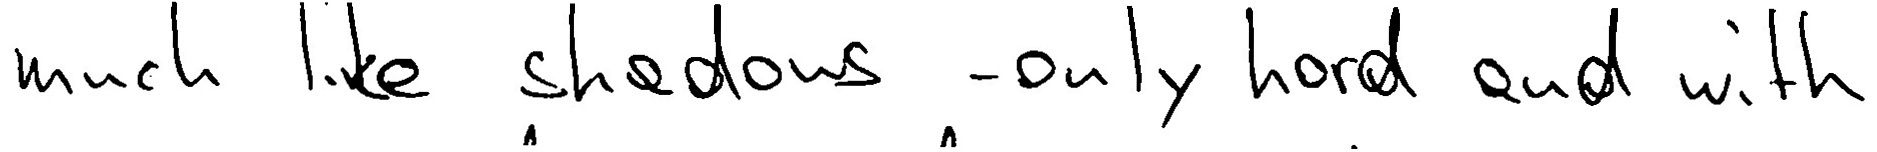

In [40]:
# Open an image from the training dataset using the file name of the first data point
image = Image.open(train_dataset.root_dir + train_df['image_name'][0]).convert("RGB")
image

In [41]:
# Extract the 'labels' tensor from the 'encoding' dictionary
labels = encoding['labels']

# Replace occurrences of -100 with the pad token ID in the 'labels' tensor
labels[labels == -100] = processor.tokenizer.pad_token_id

#`skip_special_tokens=True`: Exclude special tokens (e.g., padding tokens) from the decoded string
label_str = processor.decode(labels, skip_special_tokens=True)

print(label_str)

much like shadows only hard and with


In [42]:
from transformers import VisionEncoderDecoderModel

# Create an instance of the VisionEncoderDecoderModel using a pre-trained model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id #represents the token ID that indicates the end of a sequence, sep (separator) used to mark the end of a sequence.
#model.config.max_length = 64 # this sets an upper limit on the length of the sequences that the model will generate.
#model.config.early_stopping = True # beam search will stop generating new tokens early for each beam once it encounters the end token.
model.config.no_repeat_ngram_size = 3 # Set the size of n-grams to avoid repeating in generated sequences
#model.config.length_penalty = 2.0 # Set the length penalty factor for scoring longer sequences during beam search
model.config.num_beams = 5 #number of beams to be used in beam search

In [44]:
pip install transformers[torch]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [45]:
! pip install -U accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [46]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.36.2', '0.25.0')

In [47]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True, # Specify whether to use sequence generation during prediction
    evaluation_strategy="steps", #Specifies the strategy for performing evaluation during training, will be performed at specified steps defined by the eval_steps
    per_device_train_batch_size=8, #defines the batch size used during training on each device
    per_device_eval_batch_size=8, #defines the batch size used during evaluation on each device
    fp16=False,  # Disable mixed precision during both training and evaluation
    output_dir="./", # Specify the output directory for saving model checkpoints and logs
    logging_steps=2, # Determines how often training information is logged during training
    save_steps=1000, # Define the interval for saving model checkpoints (measured in steps)
    eval_steps=200, # Define the interval for evaluation (measured in steps)
    num_train_epochs=3
)


In [48]:
! pip install -q datasets jiwer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
from datasets import load_metric

# Load the Character Error Rate (CER) metric
cer_metric = load_metric("cer")

In [50]:
def compute_metrics(pred):

    # Extract label and prediction IDs from the 'pred' object
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode the predicted and label sequences into human-readable strings
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    # Compute the Character Error Rate (CER) using the loaded CER metric
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    # Return a dictionary with the computed CER as the metric
    return {"cer": cer}

In [51]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor, # Handle the input data for both the image and the text parts of the sequence-to-sequence task.
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator, # Handles tasks such as padding sequences and converting inputs to PyTorch tensors.
)
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


TrainOutput(global_step=150, training_loss=1.3278527690966924, metrics={'train_runtime': 355.189, 'train_samples_per_second': 6.723, 'train_steps_per_second': 0.422, 'total_flos': 2.1131303361781432e+18, 'train_loss': 1.3278527690966924, 'epoch': 3.0})

In [52]:
trainer.evaluate(train_dataset)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 0.21132776141166687,
 'eval_cer': 0.03895471978934112,
 'eval_runtime': 672.7076,
 'eval_samples_per_second': 1.183,
 'eval_steps_per_second': 0.074,
 'epoch': 3.0}

In [53]:
trainer.evaluate()

{'eval_loss': 0.32885879278182983,
 'eval_cer': 0.047058823529411764,
 'eval_runtime': 173.8779,
 'eval_samples_per_second': 1.144,
 'eval_steps_per_second': 0.075,
 'epoch': 3.0}